In [1]:
import numpy as np
import lop
import glob
import pickle

from scipy.stats import norm, beta

import pdb

import matplotlib.pyplot as plt

In [2]:
# read in a numpy saved file for the GP state


def get_filepath(env=4, run=14, trainitr=15, fake_f_name='logistic', selector='SW_ACQ_RHO'):
    #env=4
    #run=14
    #trainitr=15


    #glob_str = '../experiments/results/AT_SW_UCB_RHO_model_gp_switch_user_human_choice2_fake_'+fake_f_name+'_pareto_False_kmed_medrand_ppair_0.95_pabs_0.95_no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env'+str(env)+'_**/run_'+str(run)+'/trainitr_'+str(trainitr)+'_viz.npz'
    glob_str = '../experiments/results/AT_'+selector+'_model_gp_switch_user_human_choice2_fake_'+fake_f_name+'_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env'+str(env)+'_**/run_'+str(run)+'/trainitr_'+str(trainitr)+'_viz.npz'
    print(glob_str)
    possible = glob.glob(glob_str)
    filepath = possible[0]
    return filepath
    
#get_filepath()
#data = np.load(filepath, allow_pickle=True)
#print(data)


sim_rew_file = '../../other_repos/ice-soil-planner/scripts/plan_saving/rewards_ice_soil.pickle'
with open(sim_rew_file, 'rb') as f:
    path_data = pickle.load(f)

num_train=20
num_eval=10

train_data = [path_d[:num_train] for path_d in path_data['train']]
eval_data = [path_d[:num_eval] for path_d in path_data['eval']]

In [3]:
M=200
abs_comp = lop.AbsAcquisition(M=M, alignment_f='rho')
pair = lop.AcquisitionSelection(M=M, alignment_f='rho')
abs_l = lop.UCBLearner(1.0)
al = lop.MixedComparision(pairwise_l=pair, abs_l=abs_l, abs_comp=abs_comp, default_to_pareto=False, always_select_best=False) 

active_learner = None
rbf_sigma=1.0
rbf_l = 1.2

model = lop.PreferenceGP(
                    cov_func=lop.RBF_kern(rbf_sigma, rbf_l, sigma_noise=0.00001),
                    normalize_gp=False,
                    pareto_pairs=False,
                    normalize_positive=False,
                    use_hyper_optimization=False,
                    active_learner= al)


model.probits[0].set_sigma(0.1)
model.probits[2].set_sigma(1.0)
model.probits[2].set_v(60.0)

def model_load(model, filepath):
    data = np.load(filepath, allow_pickle=True)
    
    
    
    model.X_train = data['GP_pts']
    
    if len(data['GP_pref_0'].shape) > 0:
        model.y_train[0] = data['GP_pref_0']
    else:
        model.y_train[0] = None
        
    model.y_train[1] = None

    if len(data['GP_pref_2'].shape) > 0:
        model.y_train[2] = [data['GP_pref_2'][0], data['GP_pref_2'][1].astype(int)]
    else:
        model.y_train[2] = None
    model.prior_idx = data['GP_prior_idx']
    model.optimized = False
    
model_load(model, filepath)

NameError: name 'filepath' is not defined

../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_logistic_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env4_**/run_14/trainitr_15_viz.npz
Output hyperparameters
[ 0.1  1.  60.   1.   1.2]
../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_min_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env4_**/run_14/trainitr_10_viz.npz
Output hyperparameters
[ 0.1  1.  60.   1.   1.2]


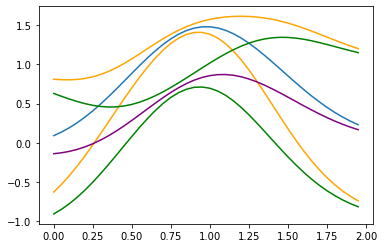

In [24]:
xs = np.arange(0, 2.0, 0.05)

X = np.array([[1.0,1.0,1.0,1.0, 1.0]])
X = xs[:,np.newaxis] @ X

model_load(model, get_filepath(trainitr=15))
y, sigma = model.predict(X)
#model.predict(np.array([[0.5, 0.7, 0.3, 0.5, 0.1], [1.2, 1.2, 1.2, 1.2, 1.2], [1.21,1.21,1.21,1.21,1.21]]))

model_load(model, get_filepath(trainitr=10, fake_f_name='min'))
y2, sigma2 = model.predict(X)



plt.plot(xs, y)
plt.plot(xs, y+sigma, color='orange')
plt.plot(xs, y-sigma, color='orange')

plt.plot(xs, y2, color='purple')
plt.plot(xs, y2+sigma2, color='green')
plt.plot(xs, y2-sigma2, color='green')
           
plt.show()

In [25]:
from sklearn_extra.cluster import KMedoids
def downsample_kmed_rand(X, num_downselect, kmed_pct=0.5):
    num_kmed = int(kmed_pct * num_downselect)
    num_rand = num_downselect - num_kmed
    
    rand_idxs = np.random.choice(X.shape[0], num_rand, replace=False)
    non_rand_idxs = list(set(list(range(X.shape[0]))) - set(rand_idxs))
    
    cent_pts = KMedoids(n_clusters=num_kmed).fit(X[non_rand_idxs]).cluster_centers_

    return np.append(cent_pts, X[rand_idxs], axis=0)

In [26]:
env = 6
index = 17

tr_pts_whole = train_data[env][index]['rewards']
tr_pts = downsample_kmed_rand(tr_pts_whole, 50)



In [27]:
model.select(tr_pts, 2)

err = 2.5775969450939156e-06
Pairwise selected metric: -0.05673734573032244
Absloute selected metric: -0.058422158413170555


[24, 33]

In [28]:
model.select(tr_pts, 2)

err = 1.9306778300021824e-08
Pairwise selected metric: -0.06226464985506103
Absloute selected metric: -0.06338677492368983


[23, 24]

In [29]:
model.select(tr_pts, 2)

err = 1.3406025632307354e-06
Pairwise selected metric: -0.06071409052574992
Absloute selected metric: -0.06204249865717333


[41, 15]

../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_logistic_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env4_**/run_14/trainitr_10_viz.npz
Output hyperparameters
[ 0.1  1.  60.   1.   1.2]
(1225,)


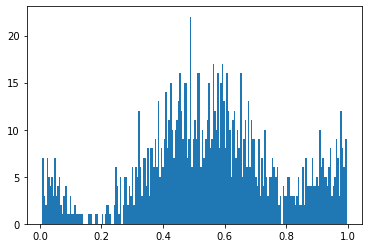

In [30]:
model_load(model, get_filepath(trainitr=10, fake_f_name='logistic'))
mu, sig = model.predict(tr_pts)

p = model.probits[0].likelihood_all_pairs(mu)

ps = p[np.triu_indices(p.shape[0], k=1)]
print(ps.shape)
plt.hist(ps, 200)
plt.show()

In [31]:
env=0
trainitr=4
index=9

M=200
abs_comp = lop.AbsAcquisition(M=M, alignment_f='rho')
pair = lop.AcquisitionSelection(M=M, alignment_f='rho')
abs_l = lop.UCBLearner(1.0)
al = lop.MixedComparision(pairwise_l=pair, abs_l=abs_l, abs_comp=abs_comp, default_to_pareto=False, always_select_best=False) 

active_learner = None
rbf_sigma=1.0
rbf_l = 1.2

model = lop.PreferenceGP(
                    cov_func=lop.RBF_kern(rbf_sigma, rbf_l, sigma_noise=0.00001),
                    normalize_gp=False,
                    pareto_pairs=False,
                    normalize_positive=False,
                    use_hyper_optimization=False,
                    active_learner= al)


model.probits[0].set_sigma(0.1)
model.probits[2].set_sigma(1.0)
model.probits[2].set_v(1000.0)

../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_logistic_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env0_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[1.0e-01 1.0e+00 1.0e+03 1.0e+00 1.2e+00]
(1225,)


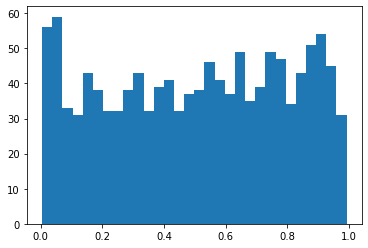

In [32]:
tr_pts_whole = train_data[env][index]['rewards']
tr_pts = downsample_kmed_rand(tr_pts_whole, 50)

model_load(model, get_filepath(trainitr=trainitr,env=env, fake_f_name='logistic'))
mu, sig = model.predict(tr_pts)

p = model.probits[0].likelihood_all_pairs(mu)

ps = p[np.triu_indices(p.shape[0], k=1)]
print(ps.shape)
plt.hist(ps, 30)
plt.show()

../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_min_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env0_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[1.0e-01 1.0e+00 1.0e+03 1.0e+00 1.2e+00]
(1225,)


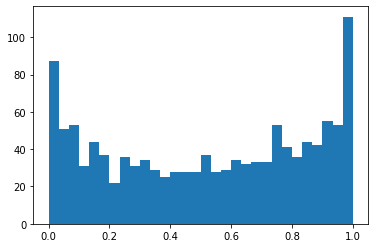

In [33]:
model_load(model, get_filepath(trainitr=trainitr,env=env, fake_f_name='min'))
mu, sig = model.predict(tr_pts)

p = model.probits[0].likelihood_all_pairs(mu)

ps = p[np.triu_indices(p.shape[0], k=1)]
print(ps.shape)
plt.hist(ps, 30)
plt.show()

../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_logistic_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env0_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[1.0e-01 1.0e+00 1.0e+03 1.0e+00 1.2e+00]
(1225,)
../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_min_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env0_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[1.0e-01 1.0e+00 1.0e+03 1.0e+00 1.2e+00]
(1225,)
../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_logistic_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env1_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[0.1 1.  1.2]
(1225,)
../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_min_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env1_**/run_14/trainitr_4_viz.npz
Output hyperparamet

/tmp/ipykernel_937871/3786169422.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_min_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env5_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[0.1 1.  1.2]
(1225,)
../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_logistic_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env6_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[1.0e-01 1.0e+00 1.0e+03 1.0e+00 1.2e+00]
(1225,)
../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_min_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env6_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[0.1 1.  1.2]
(1225,)
../experiments/results/AT_SW_ACQ_RHO_model_gp_switch_user_human_choice2_fake_logistic_pareto_False_kmed_medrand**no_v_60.0_sigabs_1.0_sigpair_0.1_rbfl_1.2_rbfsig_1.0_env7_**/run_14/trainitr_4_viz.npz
Output hyperparameters
[1.0e-01 1.0e+00 1.0e+03

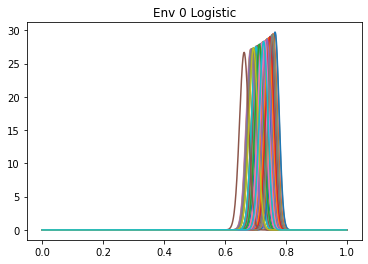

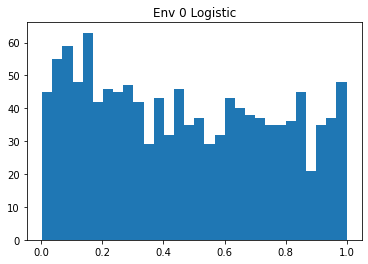

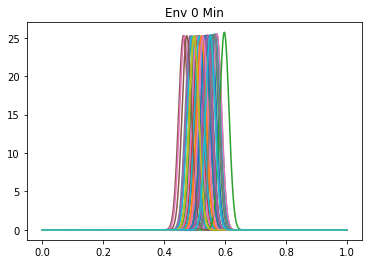

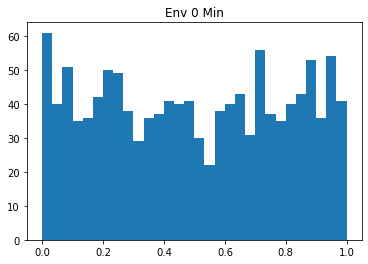

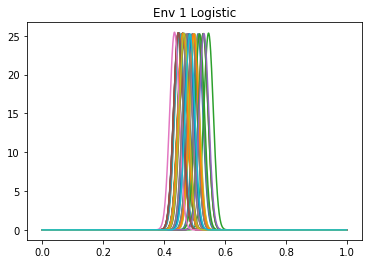

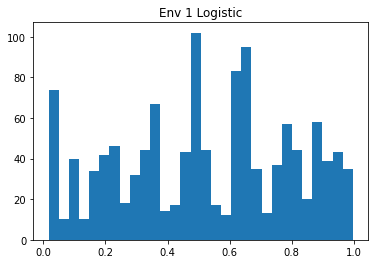

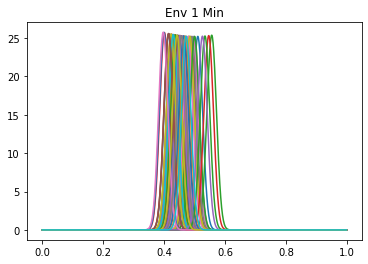

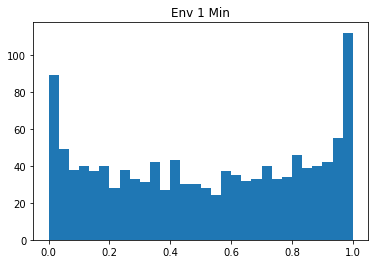

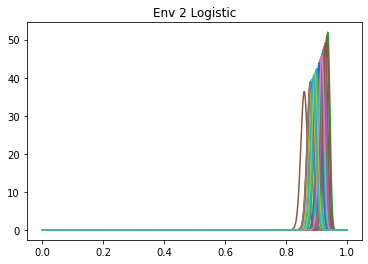

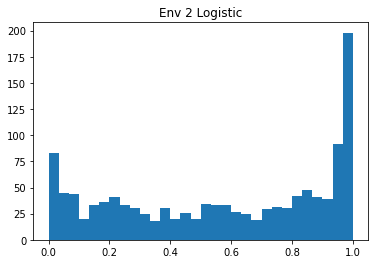

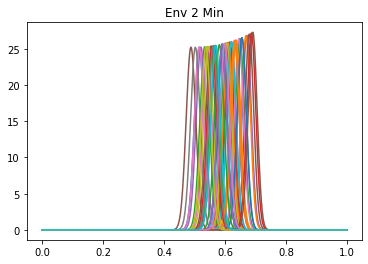

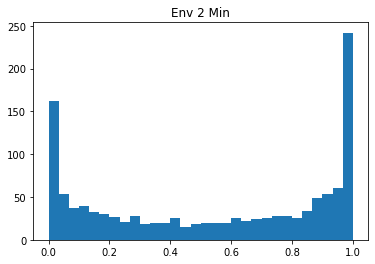

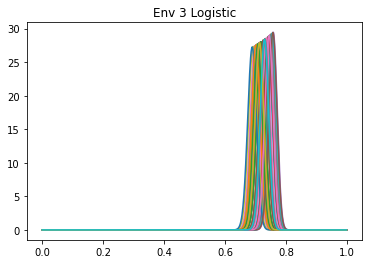

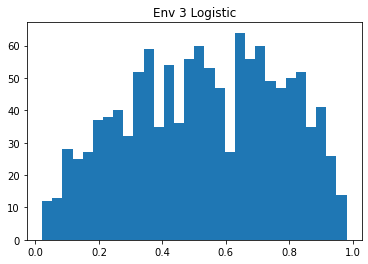

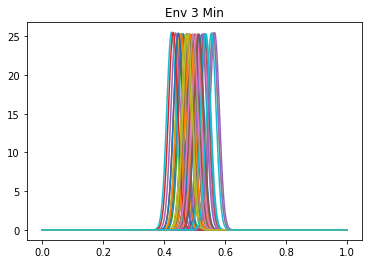

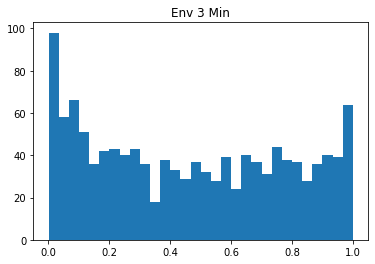

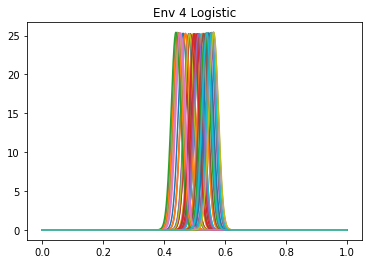

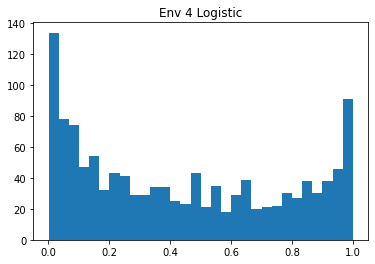

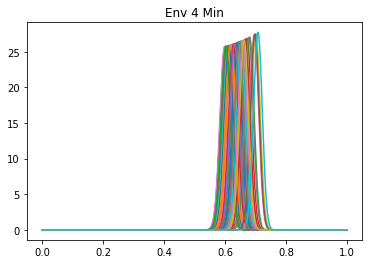

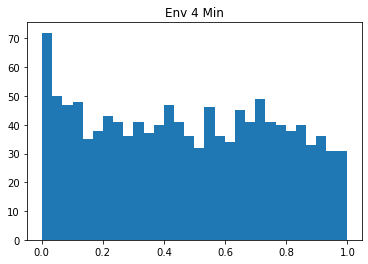

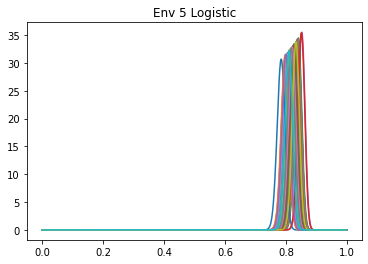

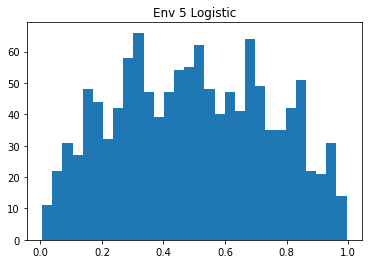

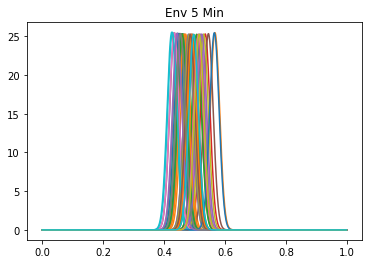

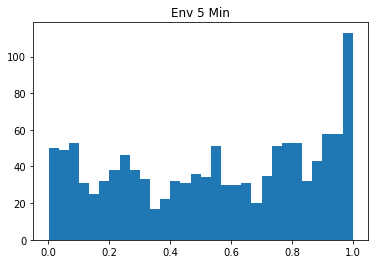

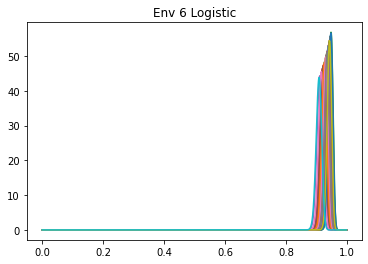

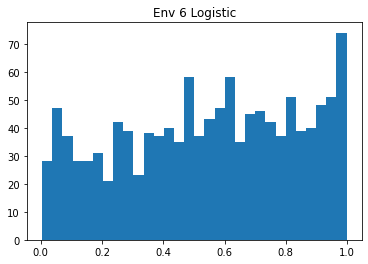

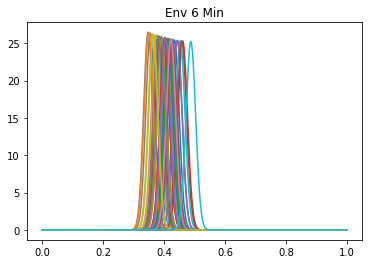

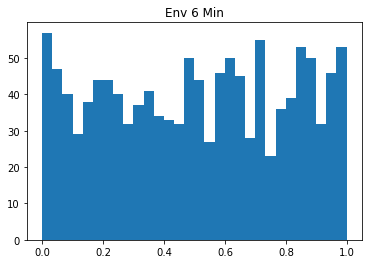

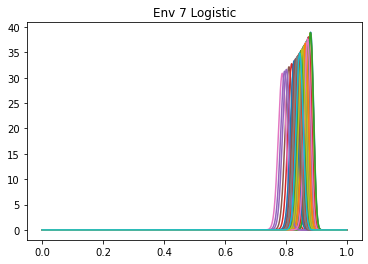

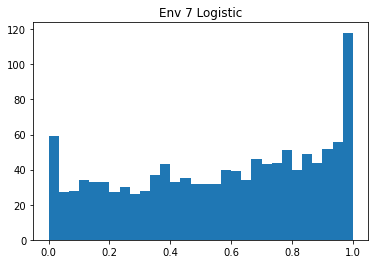

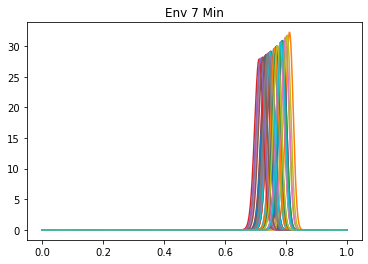

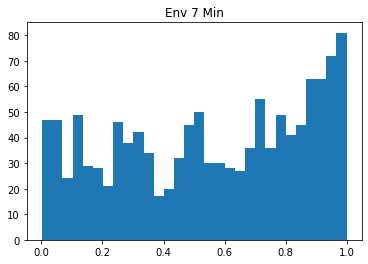

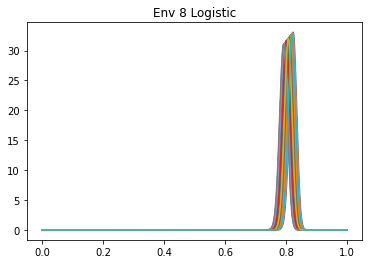

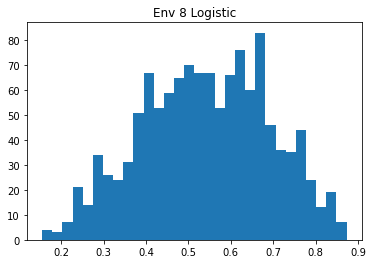

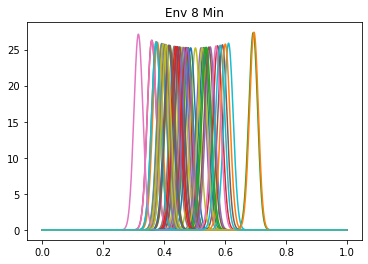

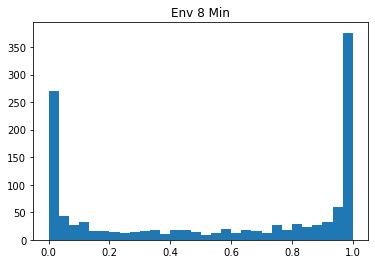

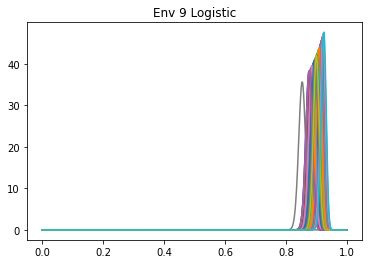

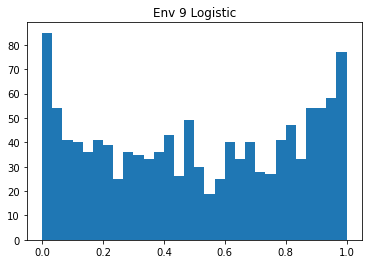

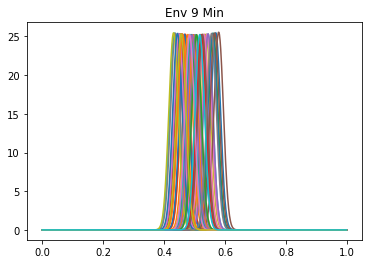

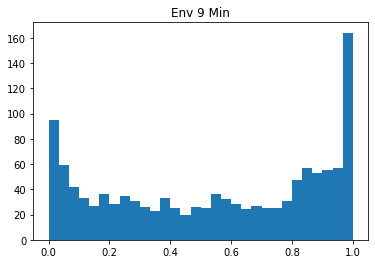

In [35]:

for env in range(10):
    tr_pts_whole = train_data[env][index]['rewards']
    tr_pts = downsample_kmed_rand(tr_pts_whole, 50)

    model_load(model, get_filepath(trainitr=trainitr,env=env, fake_f_name='logistic'))
    mu, sig = model.predict(tr_pts)

    p = model.probits[0].likelihood_all_pairs(mu)

    
    qs = np.arange(0,1,0.001)
    
    pq = np.empty((mu.shape[0], qs.shape[0]))
    
    aa, bb = model.probits[2].get_alpha_beta(mu)
    #mu_l = model.probits[2].mean_link(mu)
    
    #v = sig*50
    #aa, bb = v*mu_l, v*(1-mu_l)
    
    plt.figure()
    plt.title('Env ' + str(env) + ' Logistic')
    
    for i, q in enumerate(qs):
        pq_q = beta.pdf(q, aa, bb)
        pq[:,i] = pq_q
        

    for pq_i in pq:
        plt.plot(qs, pq_i)
    
    
    #plt.plot(qs, pq[2])
    
    
    ps = p[np.triu_indices(p.shape[0], k=1)]
    print(ps.shape)
    plt.figure()
    plt.title('Env ' + str(env) + ' Logistic')
    plt.hist(ps, 30)
    
    model_load(model, get_filepath(trainitr=trainitr,env=env, fake_f_name='min'))
    mu, sig = model.predict(tr_pts)

    p = model.probits[0].likelihood_all_pairs(mu)

    ps = p[np.triu_indices(p.shape[0], k=1)]
    print(ps.shape)
    
    aa, bb = model.probits[2].get_alpha_beta(mu)
    
    plt.figure()
    plt.title('Env ' + str(env) + ' Min')
    
    for i, q in enumerate(qs):
        pq_q = beta.pdf(q, aa, bb)
        pq[:,i] = pq_q
        

    for pq_i in pq:
        plt.plot(qs, pq_i)
    
    plt.figure()
    plt.title('Env ' + str(env) + ' Min')
    plt.hist(ps, 30)
    
plt.show()